## Option A: Binary Classification
### - *Target*: Will the song achieve sustained success? (8+ weeks in Top 200)
### - *Labels*: 1 = sustained success, 0 = brief/no success


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, matthews_corrcoef
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance



In [2]:
# Load dataset
df = pd.read_csv('Spotify_Dataset_V3_All_Clusters_v2.csv')

df

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Temporal_Cluster,Temporal_Cluster_Name,Performance_Cluster,Performance_Cluster_Name,Collab_Cluster_ID,Collab_Cluster_Name,Evo_Cluster_ID,Evo_Cluster_Name,Geo_Cluster_ID,Geo_Cluster_Name
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,...,1,Spring - Friday Fresh,1,Strong Performer,1,Hub Artist,2,Mainstream Follower,0,Local Hero
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,...,1,Spring - Friday Fresh,1,Strong Performer,1,Hub Artist,2,Mainstream Follower,0,Local Hero
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,...,1,Spring - Friday Fresh,1,Strong Performer,1,Hub Artist,0,Trend Setter,0,Local Hero
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,...,1,Spring - Friday Fresh,3,Volatile Performer,1,Hub Artist,3,Experimental/Outlier,0,Local Hero
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,...,1,Spring - Friday Fresh,3,Volatile Performer,1,Hub Artist,3,Experimental/Outlier,0,Local Hero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651931,197,Oh Lord,MiC LOWRY,01/01/2017,0.273,0.794,-6644.0,0.068,0.022,0.000,...,2,Viral/Quick Peak - Winter,0,Mid-Chart Mainstay,1,Hub Artist,0,Trend Setter,3,Western-Dominated
651932,198,Superstition - Single Version,Stevie Wonder,01/01/2017,0.650,0.658,-10908.0,0.085,0.089,0.004,...,2,Viral/Quick Peak - Winter,0,Mid-Chart Mainstay,2,Isolated/Solo Artist,2,Mainstream Follower,0,Local Hero
651933,199,Secrets,The Weeknd,01/01/2017,0.665,0.771,-5779.0,0.053,0.016,0.000,...,2,Viral/Quick Peak - Winter,0,Mid-Chart Mainstay,1,Hub Artist,2,Mainstream Follower,0,Local Hero
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",01/01/2017,0.757,0.882,-6125.0,0.248,0.076,0.000,...,2,Viral/Quick Peak - Winter,2,Lower-Chart Resident,1,Hub Artist,2,Mainstream Follower,0,Local Hero


In [3]:
weeks_per_song = df.groupby('id')['Date'].nunique().reset_index()
weeks_per_song.columns = ['id', 'total_weeks']

df = df.merge(weeks_per_song, on='id', how='left')

df['sustained_success'] = (df['total_weeks'] >= 8).astype(int)

In [4]:
# Aggregate at song level (id)
agg_dict = {
    'Danceability': 'first',
    'Energy': 'first',
    'Loudness': 'first',
    'Speechiness': 'first',
    'Acousticness': 'first',
    'Instrumentalness': 'first',
    'Valence': 'first',
    '# of Artist': 'first',
    '# of Nationality': 'first',
    'Continent': 'first',
    'Points (Total)': 'sum',
    'Sonic_Cluster': 'first',
    'Artist_Tier': 'first',
    'Temporal_Cluster': 'first',
    'Performance_Cluster': 'first',
    'Geo_Cluster_ID': 'first',
    'Collab_Cluster_ID': 'first',
    'Evo_Cluster_ID': 'first',
    'total_weeks': 'first',
    'sustained_success': 'first'
}

song_level_df = df.groupby('id').agg(agg_dict).reset_index()

In [5]:
song_level_df

,id,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,# of Nationality,...,Points (Total),Sonic_Cluster,Artist_Tier,Temporal_Cluster,Performance_Cluster,Geo_Cluster_ID,Collab_Cluster_ID,Evo_Cluster_ID,total_weeks,sustained_success
0,000xQL6tZNLJzIrtIgxqSl,0.748,0.627,-6029.00,0.064,0.131,0.0,0.524,Artist 1,Nationality 1,...,11741,1,4,4,1,3,1,3,118,1
1,003VDDA7J3Xb2ZFlNx7nIZ,0.842,0.578,-6.05,0.138,0.004,0.0,0.190,Artist 1,Nationality 1,...,252,1,4,2,0,0,1,3,2,0
2,003eoIwxETJujVWmNFMoZy,0.353,0.755,-6276.00,0.733,0.082,0.0,0.437,Artist 1,Nationality 1,...,903,0,4,5,0,0,1,0,14,1
3,003vvx7Niy0yvhvHt4a68B,0.352,0.911,-5.23,0.075,0.001,0.0,0.236,Artist 1,Nationality 1,...,18441,3,4,0,0,0,1,0,560,1
4,00B7TZ0Xawar6NZ00JFomN,0.620,0.625,-7438.00,0.553,0.287,0.0,0.665,Artist 1,Nationality 1,...,1284,0,4,1,1,0,1,2,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156,7zjEyeBsaw9gV0jofJLfOM,0.767,0.313,-12059.00,0.080,0.838,0.0,0.765,Artist 1,Nationality 1,...,209,4,4,4,0,0,1,3,8,1
9157,7zl7kehxesNEo2pYkKXTSe,0.924,0.730,-6125.00,0.274,0.053,0.0,0.848,Artist 1,Nationality 1,...,290,2,3,5,0,0,1,2,4,0
9158,7znO2T2deQ7nZUbyxEAMDB,0.570,0.535,-6.77,0.212,0.264,0.0,0.073,Artist 1,Nationality 1,...,61,3,4,5,0,0,1,1,1,0
9159,7zvfDihYiJ8RQ1nRcpKBF5,0.727,0.530,-8616.00,0.312,0.283,0.0,0.258,Artist 1,Nationality 1,...,1850,0,4,1,1,0,1,3,8,1


In [6]:
feature_cols = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
    'Instrumentalness', 'Valence', '# of Artist', '# of Nationality',
    'Continent', 'Points (Total)', 'Sonic_Cluster', 'Artist_Tier',
    'Temporal_Cluster', 'Performance_Cluster', 'Geo_Cluster_ID',
    'Collab_Cluster_ID', 'Evo_Cluster_ID'
]
X = song_level_df[feature_cols]
y = song_level_df['sustained_success']


In [7]:
from sklearn.preprocessing import LabelEncoder
for col in ['Continent','Sonic_Cluster','Artist_Tier','Temporal_Cluster',
            'Performance_Cluster','Geo_Cluster_ID','Collab_Cluster_ID','Evo_Cluster_ID']:
    if X[col].dtype == 'object' or str(X[col].dtype)=='category':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
for col in ['# of Artist', '# of Nationality']:
    X_train[col] = X_train[col].str.extract(r'(\d+)').astype(int)
    X_test[col] = X_test[col].str.extract(r'(\d+)').astype(int)


In [10]:
print(X_train.dtypes)
print(X_train.head())


Danceability           float64
Energy                 float64
Loudness               float64
Speechiness            float64
Acousticness           float64
Instrumentalness       float64
Valence                float64
# of Artist              int64
# of Nationality         int64
Continent                int64
Points (Total)           int64
Sonic_Cluster            int64
Artist_Tier              int64
Temporal_Cluster         int64
Performance_Cluster      int64
Geo_Cluster_ID           int64
Collab_Cluster_ID        int64
Evo_Cluster_ID           int64
dtype: object
      Danceability  Energy  Loudness  Speechiness  Acousticness  \
3190         0.719   0.598  -6254.00        0.077         0.232   
1007         0.442   0.619     -5.28        0.032         0.084   
2972         0.618   0.712  -8246.00        0.114         0.140   
5415         0.790   0.680  -6787.00        0.223         0.055   
5017         0.697   0.732  -6454.00        0.042         0.175   

      Instrumentalness  V

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
#logistic regression with class weight
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_pred_proba_lr = logreg.predict_proba(X_test_scaled)[:,1]

print('Logistic Regression Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba_lr))
print('\nClassification Report:\n', classification_report(y_test, y_pred_lr))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.8908892525913803
F1 Score: 0.8816568047337278
ROC-AUC: 0.9757763383501619

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90       905
           1       0.98      0.80      0.88       928

    accuracy                           0.89      1833
   macro avg       0.90      0.89      0.89      1833
weighted avg       0.90      0.89      0.89      1833

Confusion Matrix:
 [[888  17]
 [183 745]]


In [13]:
#random forest with class weight
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, class_weight='balanced', random_state=42
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print('Random Forest Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba_rf))
print('\nClassification Report:\n', classification_report(y_test, y_pred_rf))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.9328968903436988
F1 Score: 0.9334055224688684
ROC-AUC: 0.9794818060582967

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       905
           1       0.94      0.93      0.93       928

    accuracy                           0.93      1833
   macro avg       0.93      0.93      0.93      1833
weighted avg       0.93      0.93      0.93      1833

Confusion Matrix:
 [[848  57]
 [ 66 862]]


In [14]:
#xgboost with scale_pos_weight
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_proba_xgb = xgb.predict_proba(X_test_scaled)[:,1]

print('XGBoost Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('F1 Score:', f1_score(y_test, y_pred_xgb))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba_xgb))
print('\nClassification Report:\n', classification_report(y_test, y_pred_xgb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb))


XGBoost Results:
Accuracy: 0.9312602291325696
F1 Score: 0.9326923076923077
ROC-AUC: 0.9839302724328444

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       905
           1       0.92      0.94      0.93       928

    accuracy                           0.93      1833
   macro avg       0.93      0.93      0.93      1833
weighted avg       0.93      0.93      0.93      1833

Confusion Matrix:
 [[834  71]
 [ 55 873]]


In [15]:
#gradient boosting with scale_pos_weight
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=200, max_depth=6, subsample=0.8, random_state=42
)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
y_pred_proba_gb = gb.predict_proba(X_test_scaled)[:,1]

print('Gradient Boosting Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_gb))
print('F1 Score:', f1_score(y_test, y_pred_gb))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba_gb))
print('\nClassification Report:\n', classification_report(y_test, y_pred_gb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_gb))


Gradient Boosting Results:
Accuracy: 0.9312602291325696
F1 Score: 0.9328358208955224
ROC-AUC: 0.9817227090874453

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       905
           1       0.92      0.94      0.93       928

    accuracy                           0.93      1833
   macro avg       0.93      0.93      0.93      1833
weighted avg       0.93      0.93      0.93      1833

Confusion Matrix:
 [[832  73]
 [ 53 875]]


Logistic Regression ROC-AUC: 0.976
Random Forest ROC-AUC: 0.979
XGBoost ROC-AUC: 0.984
Gradient Boosting ROC-AUC: 0.982


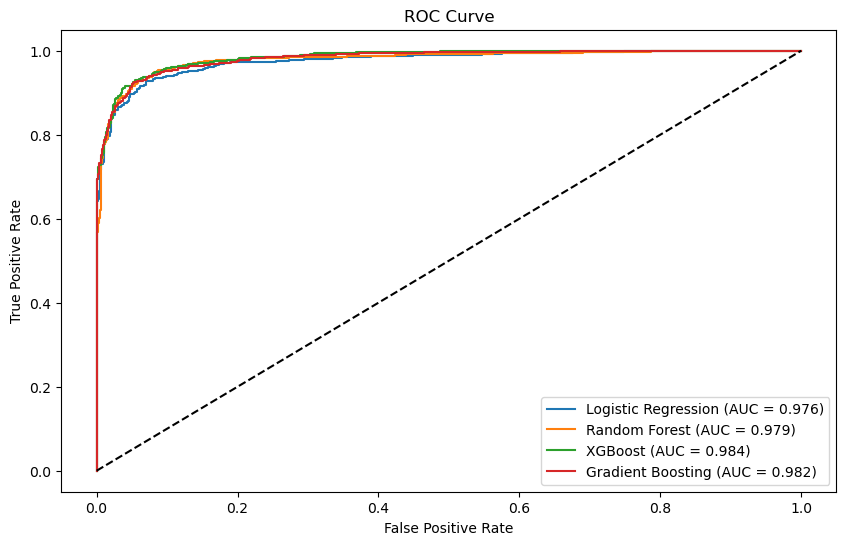

In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.3f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.3f}")
print(f"XGBoost ROC-AUC: {roc_auc_xgb:.3f}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_gb:.3f}")

#plot area under the curve for all models
from sklearn.metrics import roc_curve
plt.figure(figsize=(10, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.3f})'.format(roc_auc_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.3f})'.format(roc_auc_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.3f})'.format(roc_auc_xgb))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = {:.3f})'.format(roc_auc_gb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
